# Building a good model

## Candidate algorithms: 

### 1. logistic regression
- This is suitable for binary classification and is the litmus test for testing data's linearity, which I am not sure of.
- I will drop some features with missing data points.

### 2. KNN
- This is mainly best for multi-class classification, which is not the case here.
- Since the data does not have a huge number of dimensions, we can go with the K-D Tree for querying.
- A good approach here would be to first use K-means clustering and visualize the data.


### 3. Random forests
- Random forest classification can deal well with categorical data such as the `PRODUCT´ feature. 
- It will also not require any One-Hot-Encoding, and adding that would actually introduce sparsity we don't want.
- This is also a good candidate for improving recall in imbalanced classes.


In [ ]:
%pip install pandas
%pip install numpy
%pip install seaborn

In [205]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [206]:
dataset = pd.read_csv('../problem/churn_data.csv')

## Data Cleaning / Preprocessing

In [207]:
dataset.isnull().any()

ID                          False
PRODUCT                     False
CHURN_FLAG                  False
TENURE                      False
AVG_PLAY_120                False
AVG_PLAY_90                  True
SERIES_AVG_PLAY_LAST_120    False
SERIES_AVG_PLAY_LAST_90      True
FILM_AVG_PLAY_LAST_120      False
FILM_AVG_PLAY_LAST_90        True
dtype: bool

In [338]:
df_CHURN_LABEL = dataset.CHURN_FLAG # separating the label from the data
df_DATA = dataset[['PRODUCT', 'TENURE', 'AVG_PLAY_120', 'SERIES_AVG_PLAY_LAST_120', 'FILM_AVG_PLAY_LAST_120']] # data to include in training with dropped columns
df_DATA_no_NaN = df_DATA.fillna(df_DATA.mean())
# checking that everything went alright
print("DF Shapes")
print(df_ID.shape)
print(df_CHURN_LABEL.shape)
print(df_DATA.shape)

# One hot encoding

one_hot_encoded_DATA = pd.get_dummies(df_DATA_no_NaN,prefix=['PRODUCT'], columns=['PRODUCT'])

X, Y = np.array(df_DATA_no_NaN), np.array(df_CHURN_LABEL) 
X_OHE, Y_OHE = np.array(one_hot_encoded_DATA), np.array(df_CHURN_LABEL)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)
X_train_OHE, X_test_OHE, y_train_OHE, y_test_OHE =  train_test_split(X_OHE, Y_OHE, test_size=0.25, shuffle=True)


DF Shapes
(39121,)
(39121,)
(39121, 5)


### Logistic Regression

We can see below that this is a bad choice. Given that the majority of our rows have a `CHURN_FLAG` label of `1`, it's entirely possible to get a relatively high accuracy from the first try (such as `89%`) but with a very small macro f1-score (of `44%`).

This is a sign of over-fitting, despite having removed redundant features, performed one hot encoding, and added L2 regularization.

This model should therefore be eliminated.


In [270]:
pca = PCA()
logistic = LogisticRegression(max_iter=10000, tol=1e-4, penalty='l2')
pipe = Pipeline(steps=[('pca', pca), ('standardscaler', StandardScaler()), ('logistic', logistic)])
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train_OHE, y_train_OHE)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

y_pred = search.predict(X_test_OHE)
print(classification_report(y_test_OHE, y_pred))


Best parameter (CV score=0.885):
{'logistic__C': 0.0001, 'pca__n_components': 5}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1182
           1       0.88      1.00      0.94      8599

    accuracy                           0.88      9781
   macro avg       0.44      0.50      0.47      9781
weighted avg       0.77      0.88      0.82      9781



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


First, I wanted to see if it were possible for the K-means algorithm to find any clusters. As can be seen below, the answer is, *"no"*.

The k-means algorithm detects clusters that do not relate to how the data is shaped. 

Text(0.5, 1.0, 'Real labels on TENURE plotted against AVG_PLAY_120 using PCA dimensionality reduction')

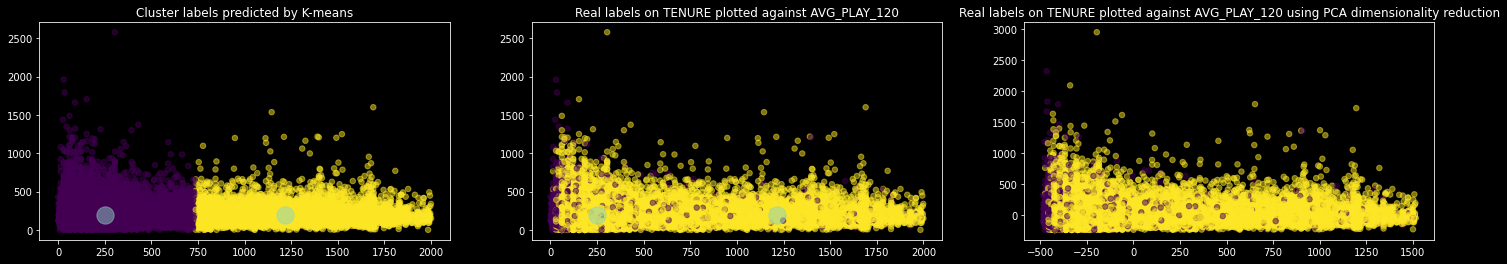

In [271]:
kmeans = KMeans(n_clusters=2, algorithm='full')
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(25,4)) 
ax1.scatter(X[:, 1], X[:, 2], c=y_kmeans, s=30, cmap='viridis', alpha=0.5) 
ax2.scatter(X[:, 1], X[:, 2], c=Y, s=30, cmap='viridis', alpha=0.5)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
ax3.scatter(pca_result[:, 0], pca_result[:, 1], c=Y, s=30, cmap='viridis', alpha=0.5) 

centers = kmeans.cluster_centers_
ax1.scatter(centers[:, 1], centers[:, 2], s=300, alpha=0.5)
ax2.scatter(centers[:, 1], centers[:, 2], s=300, alpha=0.5)

ax1.set_title('Cluster labels predicted by K-means')
ax2.set_title('Real labels on TENURE plotted against AVG_PLAY_120')
ax3.set_title('Real labels on TENURE plotted against AVG_PLAY_120 using PCA dimensionality reduction')


In [ ]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)

plt.scatter(tsne_result[:100, 0], tsne_result[:100, 1], c=Y, s=30, cmap='viridis', alpha=0.5) 


### Random Forests

#### Using the scikit-learn Random Forest classifier already gives us better results, as seen below:

However, it is clear that recall for `CHURN_FLAG`=`0` needs to be improved. 

In [319]:
def rfc(X_train_set, y_train_set, X_test_set, y_test_set, max_depth=40, random_state=0, min_samples_leaf = 3, min_samples_split = 4, n_estimators = 200):
    random_forest = RandomForestClassifier(max_depth=max_depth, random_state=random_state, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators )
    model = random_forest.fit(X_train_set, y_train_set.ravel())

    y_pred = model.score(X_test_set, y_test_set)

    acc_model = round(model.score(X_test_set, y_test_set) * 100, 2)
    print("Model Accuracy:", round(acc_model,2,), "%")
    y_pred = model.predict(X_test_set)
    print(classification_report(y_test_set, y_pred))



In [328]:
from sklearn.ensemble import RandomForestClassifier

# scaling data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.fit_transform(X_test, y_test)

rfc(X_train_scaled, y_train, X_test_scaled, y_test)


Model Accuracy: 86.68 %
              precision    recall  f1-score   support

           0       0.42      0.43      0.43      1117
           1       0.93      0.92      0.92      8664

    accuracy                           0.87      9781
   macro avg       0.67      0.68      0.68      9781
weighted avg       0.87      0.87      0.87      9781



After taking a quick look at the most important features for this random forest classifier, we find that the `PRODUCT` feature has the lowest importance score of all.


<AxesSubplot:xlabel='feature'>

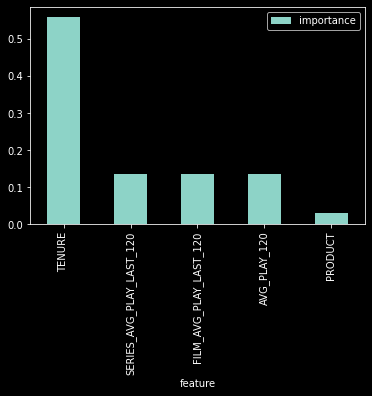

In [330]:
importances = pd.DataFrame({'feature':df_DATA.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)
importances[:15].plot.bar()

I thought that removing it is likely to improve recall which it did (from `42%` to `48%`); but, as shown below, there was quite a decrease in precision. Our macro-averaged F1-score has also dropped.

In [332]:
# Random forest classifier with product removed
rfc(X_train_scaled[:, 1:], y_train, X_test_scaled[:, 1:], y_test)



Model Accuracy: 81.82 %
              precision    recall  f1-score   support

           0       0.31      0.48      0.38      1117
           1       0.93      0.86      0.89      8664

    accuracy                           0.82      9781
   macro avg       0.62      0.67      0.63      9781
weighted avg       0.86      0.82      0.83      9781



Another means of improving the score would be to use the One Hot Encoded `PRODUCT` feature. This seems to significantly improve precision while creating a drop in recall. The overall accuracy is higher.

In [348]:
X_train_OHE_scaled = scaler.fit_transform(X_train_OHE, y_train_OHE)
X_test_OHE_scaled = scaler.fit_transform(X_test_OHE, y_test_OHE)

rfc(X_train_OHE_scaled, y_train_OHE, X_test_OHE_scaled, y_test_OHE)


Model Accuracy: 90.75 %
              precision    recall  f1-score   support

           0       0.76      0.35      0.48      1193
           1       0.92      0.98      0.95      8588

    accuracy                           0.91      9781
   macro avg       0.84      0.67      0.71      9781
weighted avg       0.90      0.91      0.89      9781

